In [1]:
import sys
sys.path.append('/teams/YingChiLab_1702378116/KexuanKong/sc-GPT/TOSICA-main')  # 替换为实际路径

In [2]:
import TOSICA
import scanpy as sc
import numpy as np
import warnings 
warnings.filterwarnings ("ignore")

Information of GPU

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.get_device_capability(device=None),  torch.cuda.get_device_name(device=None))

2.2.0+cu121
(8, 6) NVIDIA RTX A2000 12GB


Reference data

In [4]:
ref_adata = sc.read('demo_train.h5ad')
ref_adata = ref_adata[:,ref_adata.var_names]
print(ref_adata)
print(ref_adata.obs.Celltype.value_counts())

View of AnnData object with n_obs × n_vars = 10600 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
Celltype
alpha          3136
beta           2966
ductal         1290
acinar         1144
delta           793
PSC             524
PP              356
endothelial     273
macrophage       52
mast             25
epsilon          21
schwann          13
t_cell            7
Name: count, dtype: int64


Query data

In [5]:
query_adata = sc.read('demo_test.h5ad')
query_adata = query_adata[:,query_adata.var_names]
print(query_adata)
print(query_adata.obs.Celltype.value_counts())

View of AnnData object with n_obs × n_vars = 4218 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
Celltype
alpha           2011
beta            1006
ductal           414
PP               282
acinar           209
delta            188
PSC               73
endothelial       16
epsilon            7
mast               7
MHC class II       5
Name: count, dtype: int64


Training:

In [6]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype',epochs=3,project='hGOBP_demo')
!ls ./hGOBP_demo

cuda:0
Mask loaded!
Model builded!


[valid epoch 2] loss: 0.068, acc: 0.988: 100%|██████████| 1528/1528 [00:12<00:00, 125.70it/s]


Training finished!
gene2token_weights.csv	mask.npy     model-1.pth  pathway.csv
label_dictionary.csv	model-0.pth  model-2.pth


Prediction

In [7]:
model_weight_path = './hGOBP_demo/model-0.pth'
new_adata = TOSICA.pre(query_adata, model_weight_path = model_weight_path,project='hGOBP_demo')

cuda:0
0
4218


In [8]:
new_adata.write('demo_attn.h5ad')
new_adata

AnnData object with n_obs × n_vars = 4218 × 299
    obs: 'Prediction', 'Probability', 'Celltype'

In [9]:
new_adata.raw = new_adata
sc.pp.filter_genes(new_adata, min_counts=1)
# 2. 不过滤细胞（默认行为）
# 注意：如果之前有过滤过细胞的代码，请注释掉
# 3. 归一化
sc.pp.normalize_total(new_adata, target_sum=1e4)
# 4. log1p
sc.pp.log1p(new_adata)
# 5. 不进行 HVG 筛选
# 不执行 sc.pp.highly_variable_genes()
# 6. 可选：是否 binning，看你是否需要完全一致（略）
# PCA 和 UMAP 保持一致设置
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_adata, random_state=0)


In [13]:
new_adata.raw = new_adata
sc.pp.normalize_total(new_adata, target_sum=1e4)
sc.pp.log1p(new_adata)
sc.pp.scale(new_adata, max_value=10)
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_adata)

In [10]:
# 预定义颜色（多一些，确保足够）
col = np.array([
    "#98DF8A", "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3",
    "#FF7F00", "#FFFF33", "#A65628", "#F781BF", "#999999",
    "#1F77B4", "#FF7F0E", "#279E68", "#FF9896", "#AEC7E8",
    "#C5B0D5", "#C49C94"
]).astype('<U7')

# ---------- Prediction 列 ----------
# 获取 Prediction 中实际的类别
pred_categories = list(new_adata.obs['Prediction'].astype('category').cat.categories)

# 将 Prediction 列转为 category 并重新排序（如果你有特定顺序请修改下面这一行）
desired_pred_order = pred_categories  # 或你手动设定的顺序
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].astype('category')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].cat.reorder_categories(desired_pred_order, ordered=False)

# 设置 Prediction_colors
new_adata.uns['Prediction_colors'] = col[:len(desired_pred_order)]

# ---------- Celltype 列 ----------
# 获取 Celltype 中实际的类别
celltype_categories = list(new_adata.obs['Celltype'].astype('category').cat.categories)

# 将 Celltype 列转为 category 并重新排序（如有特定顺序，请自定义）
desired_celltype_order = celltype_categories  # 或你手动设定的顺序
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].astype('category')
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].cat.reorder_categories(desired_celltype_order, ordered=False)

# 设置 Celltype_colors
new_adata.uns['Celltype_colors'] = col[:len(desired_celltype_order)]


In [11]:
# 🟦 提前准备足够的颜色（多准备几个以防不足）
col = np.array([
    "#98DF8A","#E41A1C" ,"#377EB8", "#4DAF4A" ,"#984EA3" ,"#FF7F00" ,"#FFFF33" ,"#A65628" ,"#F781BF" ,"#999999","#1F77B4","#FF7F0E","#279E68","#FF9896"
]).astype('<U7')

# 🟨 1. 提取两个列中所有的细胞类型
pred_types = new_adata.obs['Prediction'].astype('category').cat.categories.tolist()
cell_types = new_adata.obs['Celltype'].astype('category').cat.categories.tolist()

# 🟩 2. 合并去重，生成统一的细胞类型顺序
all_types = list(dict.fromkeys(pred_types + cell_types))  # 保持顺序去重

# 🟥 3. 为每个细胞类型分配颜色
type_to_color = dict(zip(all_types, col[:len(all_types)]))

# 🟦 4. 设置 Prediction 列和颜色
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].astype('category')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].cat.reorder_categories(pred_types, ordered=False)
new_adata.uns['Prediction_colors'] = [type_to_color[ct] for ct in pred_types]

# 🟧 5. 设置 Celltype 列和颜色
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].astype('category')
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].cat.reorder_categories(cell_types, ordered=False)
new_adata.uns['Celltype_colors'] = [type_to_color[ct] for ct in cell_types]


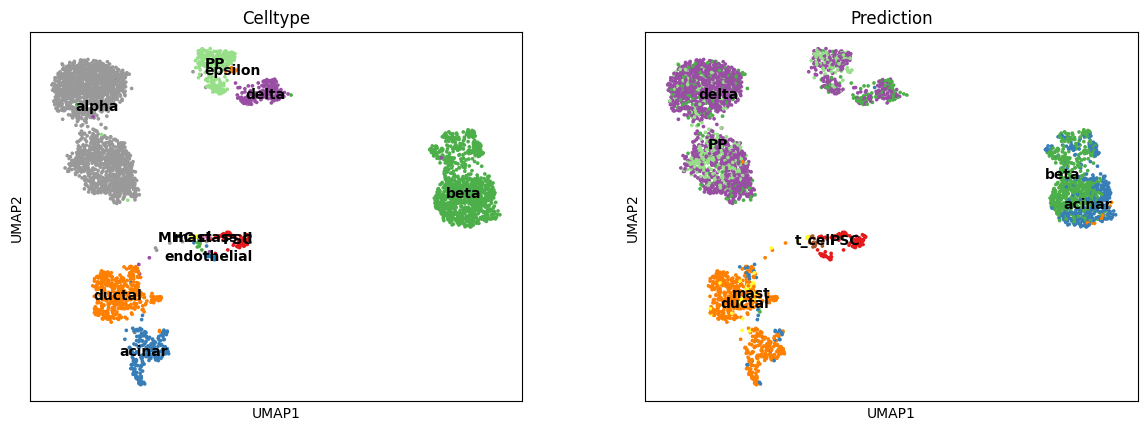

In [12]:
sc.pl.umap(new_adata, color=['Celltype', 'Prediction'],legend_loc='on data')

In [13]:
from sklearn.metrics import classification_report

# 确保 Prediction 和 Celltype 是字符串类型（避免 pandas 的分类对不上）
y_pred = new_adata.obs['Prediction'].astype(str)
y_true = new_adata.obs['Celltype'].astype(str)

# 生成完整的分类报告
report = classification_report(y_true, y_pred, digits=3)
print(report)


              precision    recall  f1-score   support

MHC class II      0.000     0.000     0.000         5
          PP      0.197     0.319     0.243       282
         PSC      0.745     0.959     0.838        73
      acinar      0.050     0.100     0.066       209
       alpha      0.000     0.000     0.000      2011
        beta      0.664     0.604     0.633      1006
       delta      0.052     0.473     0.094       188
      ductal      0.649     0.872     0.744       414
 endothelial      0.000     0.000     0.000        16
     epsilon      0.000     0.000     0.000         7
        mast      0.091     0.571     0.157         7
      t_cell      0.000     0.000     0.000         0

    accuracy                          0.295      4218
   macro avg      0.204     0.325     0.231      4218
weighted avg      0.253     0.295     0.262      4218



Training on pre-weights of 'human_gobp' mask:

In [14]:
!cp ./hGOBP_demo/model-0.pth ./pre_weights.pth

In [15]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype',epochs=3,project='hGOBP_demo')
!ls ./hGOBP_demo

cuda:0
Mask loaded!
Model builded!


[valid epoch 2] loss: 0.068, acc: 0.988: 100%|██████████| 1528/1528 [00:12<00:00, 126.03it/s]


Training finished!
gene2token_weights.csv	mask.npy     model-1.pth  pathway.csv
label_dictionary.csv	model-0.pth  model-2.pth


In [16]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype',pre_weights='pre_weights.pth',epochs=1)

cuda:0
Mask loaded!
<All keys matched successfully>
Model builded!


[valid epoch 0] loss: 0.067, acc: 0.987: 100%|██████████| 1528/1528 [00:11<00:00, 128.31it/s]


Training finished!


In [29]:
model_weight_path = './human_gobp_20250513/model-0.pth'
new_all_adata = TOSICA.pre(query_adata, model_weight_path = model_weight_path,project='human_gobp_20250513')

cuda:0
0
4218


In [32]:
new_all_adata.write('finetune_attn.h5ad')
new_all_adata

AnnData object with n_obs × n_vars = 4218 × 299
    obs: 'Prediction', 'Probability', 'Celltype'

In [17]:
new_adata = sc.read('finetune_attn.h5ad')

In [18]:
new_adata

AnnData object with n_obs × n_vars = 4218 × 299
    obs: 'Prediction', 'Probability', 'Celltype'

In [19]:
new_adata.raw = new_adata
sc.pp.filter_genes(new_adata, min_counts=1)
# 2. 不过滤细胞（默认行为）
# 注意：如果之前有过滤过细胞的代码，请注释掉
# 3. 归一化
sc.pp.normalize_total(new_adata, target_sum=1e4)
# 4. log1p
sc.pp.log1p(new_adata)
# 5. 不进行 HVG 筛选
# 不执行 sc.pp.highly_variable_genes()
# 6. 可选：是否 binning，看你是否需要完全一致（略）
# PCA 和 UMAP 保持一致设置
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_adata, random_state=0)

In [8]:
new_all_adata.raw = new_all_adata
sc.pp.normalize_total(new_all_adata, target_sum=1e4)
sc.pp.log1p(new_all_adata)
sc.pp.scale(new_all_adata, max_value=10)
sc.tl.pca(new_all_adata, svd_solver='arpack')
sc.pp.neighbors(new_all_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_all_adata)

In [21]:
from sklearn.metrics import classification_report

# 确保 Prediction 和 Celltype 是字符串类型（避免 pandas 的分类对不上）
y_pred = new_adata.obs['Prediction'].astype(str)
y_true = new_adata.obs['Celltype'].astype(str)

# 生成完整的分类报告
report = classification_report(y_true, y_pred, digits=3)
print(report)

report_dict = classification_report(y_true, y_pred, output_dict=True)

macro_avg_f1 = report_dict['macro avg']['f1-score']
macro_avg_recall = report_dict['macro avg']['recall']
macro_avg_precision = report_dict['macro avg']['precision']

weighted_avg_f1 = report_dict['weighted avg']['f1-score']
weighted_avg_recall = report_dict['weighted avg']['recall']
weighted_avg_precision = report_dict['weighted avg']['precision']

# 输出总体的F1 score, recall, precision
print(f"Macro Average F1: {macro_avg_f1:.4f}")
print(f"Macro Average Recall: {macro_avg_recall:.4f}")
print(f"Macro Average Precision: {macro_avg_precision:.4f}")

print(f"Weighted Average F1: {weighted_avg_f1:.4f}")
print(f"Weighted Average Recall: {weighted_avg_recall:.4f}")
print(f"Weighted Average Precision: {weighted_avg_precision:.4f}")

              precision    recall  f1-score   support

MHC class II      0.000     0.000     0.000         5
          PP      0.993     1.000     0.996       282
         PSC      1.000     0.959     0.979        73
      acinar      0.988     0.407     0.576       209
       alpha      0.998     0.991     0.995      2011
        beta      0.991     0.971     0.981      1006
       delta      0.943     0.963     0.953       188
      ductal      0.763     0.988     0.861       414
 endothelial      0.615     1.000     0.762        16
     epsilon      0.875     1.000     0.933         7
  macrophage      0.000     0.000     0.000         0
        mast      0.286     0.857     0.429         7
     schwann      0.000     0.000     0.000         0

    accuracy                          0.954      4218
   macro avg      0.650     0.703     0.651      4218
weighted avg      0.966     0.954     0.952      4218

Macro Average F1: 0.6511
Macro Average Recall: 0.7027
Macro Average Precision: 

In [ ]:
输出的内容：
宏平均（Macro avg）: 这些是你不考虑每种细胞类型的数量，计算出的平均值。

加权平均（Weighted avg）: 考虑每个类别的样本数量，并根据它们的权重来计算平均值。

3. 结果解释：
Precision: 测试中正确预测为某一类的样本数占所有预测为该类的样本数的比例。

Recall: 测试中正确预测为某一类的样本数占所有实际为该类的样本数的比例。

F1 Score: Precision 和 Recall 的调和平均数，综合了两者的影响。公式：F1 = 2 * (precision * recall) / (precision + recall)。

4. 使用 macro avg 和 weighted avg：
Macro average 是每个类的指标平均值，它不受各个类别样本数量的影响。适用于对每个类别的表现平等关注的情况。

Weighted average 是对每个类的指标按照其样本数加权计算平均值。适用于样本数量不平衡的情况，可以给较大类更多的权重。

如果你只关心整体评估结果，使用 weighted avg 是更合适的选择，因为它考虑了不同类别的样本数。

In [25]:
# 🟦 提前准备足够的颜色（多准备几个以防不足）
col = np.array([
    "#98DF8A","#E41A1C" ,"#377EB8", "#4DAF4A" ,"#984EA3" ,"#FF7F00" ,"#FFFF33" ,"#A65628" ,"#F781BF" ,"#999999","#1F77B4","#FF7F0E","#279E68","#FF9896"
]).astype('<U7')

# 🟨 1. 提取两个列中所有的细胞类型
pred_types = new_adata.obs['Prediction'].astype('category').cat.categories.tolist()
cell_types = new_adata.obs['Celltype'].astype('category').cat.categories.tolist()

# 🟩 2. 合并去重，生成统一的细胞类型顺序
all_types = list(dict.fromkeys(pred_types + cell_types))  # 保持顺序去重

# 🟥 3. 为每个细胞类型分配颜色
type_to_color = dict(zip(all_types, col[:len(all_types)]))

# 🟦 4. 设置 Prediction 列和颜色
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].astype('category')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].cat.reorder_categories(pred_types, ordered=False)
new_adata.uns['Prediction_colors'] = [type_to_color[ct] for ct in pred_types]

# 🟧 5. 设置 Celltype 列和颜色
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].astype('category')
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].cat.reorder_categories(cell_types, ordered=False)
new_adata.uns['Celltype_colors'] = [type_to_color[ct] for ct in cell_types]


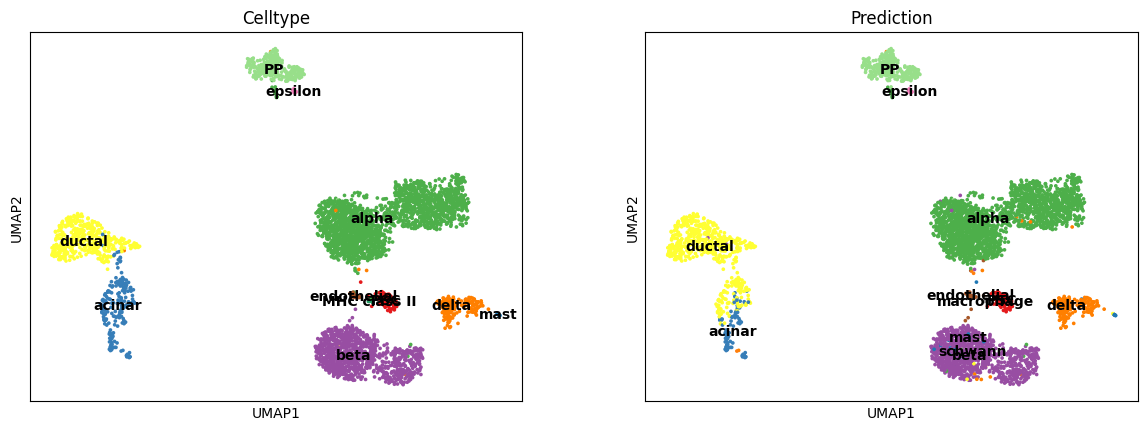

In [26]:
sc.pl.umap(new_adata, color=['Celltype', 'Prediction'],legend_loc='on data')

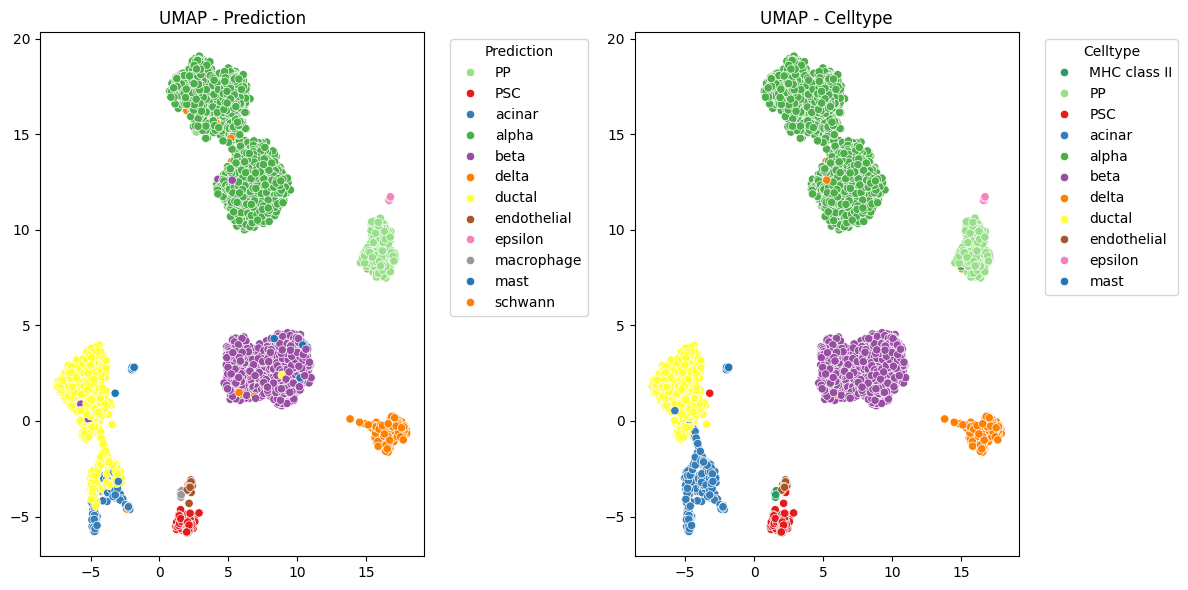

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🟦 提前准备足够的颜色（多准备几个以防不足）
col = np.array([
    "#98DF8A","#E41A1C" ,"#377EB8", "#4DAF4A" ,"#984EA3" ,"#FF7F00" ,"#FFFF33" ,"#A65628" ,"#F781BF" ,"#999999","#1F77B4","#FF7F0E","#279E68","#FF9896"
]).astype('<U7')

# 🟨 1. 提取两个列中所有的细胞类型
pred_types = new_all_adata.obs['Prediction'].astype('category').cat.categories.tolist()
cell_types = new_all_adata.obs['Celltype'].astype('category').cat.categories.tolist()

# 🟩 2. 合并去重，生成统一的细胞类型顺序
all_types = list(dict.fromkeys(pred_types + cell_types))  # 保持顺序去重

# 🟥 3. 为每个细胞类型分配颜色
type_to_color = dict(zip(all_types, col[:len(all_types)]))

# 🟦 4. 设置 Prediction 列和颜色
new_all_adata.obs['Prediction'] = new_all_adata.obs['Prediction'].astype('category')
new_all_adata.obs['Prediction'] = new_all_adata.obs['Prediction'].cat.reorder_categories(pred_types, ordered=False)
new_all_adata.uns['Prediction_colors'] = [type_to_color[ct] for ct in pred_types]

# 🟧 5. 设置 Celltype 列和颜色
new_all_adata.obs['Celltype'] = new_all_adata.obs['Celltype'].astype('category')
new_all_adata.obs['Celltype'] = new_all_adata.obs['Celltype'].cat.reorder_categories(cell_types, ordered=False)
new_all_adata.uns['Celltype_colors'] = [type_to_color[ct] for ct in cell_types]

# 画出 UMAP 或其他可视化，并添加图例
# 下面是基于 Prediction 和 Celltype 的 UMAP 可视化示例
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# UMAP 可视化 Celltype
sns.scatterplot(
    x=new_all_adata.obsm['X_umap'][:, 0], 
    y=new_all_adata.obsm['X_umap'][:, 1], 
    hue=new_all_adata.obs['Celltype'], 
    palette=new_all_adata.uns['Celltype_colors'], 
    ax=ax[1]
)
ax[1].set_title('UMAP - Celltype')
ax[1].legend(title='Celltype', bbox_to_anchor=(1.05, 1), loc='upper left')

# UMAP 可视化 Prediction
sns.scatterplot(
    x=new_all_adata.obsm['X_umap'][:, 0], 
    y=new_all_adata.obsm['X_umap'][:, 1], 
    hue=new_all_adata.obs['Prediction'], 
    palette=new_all_adata.uns['Prediction_colors'], 
    ax=ax[0]
)
ax[0].set_title('UMAP - Prediction')
ax[0].legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
